In [1]:
import numpy as np
import math

np.set_printoptions(precision=3)

class Unitary2(object):
    """
    Create a 2x2 unitary matrix from three angles, specify in radians.

    We'll use the decomposition shown in wikipedia.
    U = exp(i*phi) * m3 @ m2 @ m1, where
    m3 = [[exp(i*psi), 0], [0, exp(-i*psi)]]
    m2 = [[cos(theta), sin(theta)], [-sin(theta), cos(theta)]]
    m1 = [[exp(i*delta), 0], [0, exp(-i*delta)]]
    """
    def __init__(self, psi, theta, delta, phi=0.0) -> None:
        self._psi = psi
        self._theta = theta
        self._delta = delta
        self._phi = phi
        self._build_matrix()

    def _build_matrix(self):
        exp_psi = np.exp(1j * self.psi)
        c = np.cos(self.theta)
        s = np.sin(self.theta)
        exp_delta = np.exp(1j * self.delta)

        m1 = np.array([[exp_delta, 0.0], [0.0, np.conj(exp_delta)]])
        m2 = np.array([[c, s], [-s, c]])
        m3 = np.array([[exp_psi, 0.0], [0.0, np.conj(exp_psi)]])

        self.matrix = np.exp(1j * self.phi) * m3 @ m2 @ m1
        self._is_unitary()

    # Below allow us to change the settings of the unitary, and
    # rebuild the matrix.
    @property
    def psi(self):
        return self._psi

    @psi.setter
    def psi(self, val):
        self._psi = val
        self._build_matrix()

    @property
    def theta(self):
        return self._theta

    @theta.setter
    def theta(self, val):
        self._theta = val
        self._build_matrix()

    @property
    def delta(self):
        return self._delta

    @delta.setter
    def delta(self, val):
        self._delta = val
        self._build_matrix()

    @property
    def phi(self):
        return self._phi

    @phi.setter
    def phi(self, val):
        self._phi = val
        self._build_matrix()

    ###

    def _is_unitary(self):
        # check that it's a unitary matrix
        assert np.allclose(self.matrix @ self.matrix.conj().T, np.identity(2))
        assert np.allclose(self.matrix.conj().T @ self.matrix, np.identity(2))

    def forward(self, x):
        return self.matrix @ x

    def backward(self, x):
        return self.matrix.T @ x

    def __repr__(self):
        return f"(ψ,δ,θ,φ) = ({self.psi/np.pi}, {self.delta/np.pi}, {self.theta/np.pi}, {self.phi/np.pi})*π\n" + \
            f"Matrix:\n{self.matrix}"

class MZI(Unitary2):
    def __init__(self, theta) -> None:
        super().__init__(psi=0.0, theta=theta, delta=0.0, phi=0.0)

    def _build_matrix(self):  # can only change theta in an MZI
        super()._build_matrix()
        assert(np.allclose([self.psi, self.delta, self.phi], np.zeros(3)))


class PhaseShifter(Unitary2):
    def __init__(self, phase) -> None:
        super().__init__(psi=phase, theta=0.0, delta=0.0, phi=0.0)

    def _build_matrix(self):  # can only change psi in a phase shifter
        super()._build_matrix()
        assert (np.allclose([self.theta, self.delta, self.phi], np.zeros(3)))

    @property
    def phase(self):
        return self._psi

    @phase.setter
    def phase(self, val):
        self.psi = val


class Fiber(Unitary2):
    """
    Creat a random 2x2 unitary that represents the fiber rotation
    """
    def __init__(self) -> None:
        rvals = np.random.default_rng().uniform(-np.pi, np.pi, 3)
        super().__init__(psi=rvals[0], theta=rvals[1], delta=rvals[2])

# Find a solution assuming we know the fiber's transformation

Each chip uses the top (TE) port for TX and the bottom (TM) port for RX.
Show that there is a solution where:
- Signals from TX1 (top port of 1) will go to RX2 (bottom port of 2) in the
forward direction, and
- Signals from TX2 (top port of 2) will go to RX1 (bottom port of 1) in the
backward direction.

In [2]:
mzi_ctrl_1 = MZI(theta=0.0)
phase_ctrl_1 = PhaseShifter(0.0)

fiber = Fiber()  # random fiber transformation

phase_ctrl_2 = PhaseShifter(phase=-1.0*fiber.psi)  # undo the phase transformation
mzi_ctrl_2 = MZI(theta=-1.0*fiber.theta + math.radians(90))
# undo the rotational transformation & add a swap (90 degree rotation)

# For signals going from 1 --> 2
x = [1.0, 0.0]  # initially all signals are on the top port
x = mzi_ctrl_1.forward(x)
x = phase_ctrl_1.forward(x)
x = fiber.forward(x)
x = phase_ctrl_2.forward(x)
x = mzi_ctrl_2.forward(x)

print(np.abs(x))
print(
    f"All signals go to the bottom port? {np.allclose(np.abs(x), [0.0, 1.0])}"
)

# For signals going from 2 --> 1
x = [1.0, 0.0]  # initially all signals are on the top port
x = mzi_ctrl_2.backward(x)
x = phase_ctrl_2.backward(x)
x = fiber.backward(x)
x = phase_ctrl_1.backward(x)
x = mzi_ctrl_1.backward(x)

print(np.abs(x))
print(
    f"All signals go to the bottom port? {np.allclose(np.abs(x), [0.0, 1.0])}"
)


[1.519e-16 1.000e+00]
All signals go to the bottom port? True
[1.558e-16 1.000e+00]
All signals go to the bottom port? True


# Find a solution *without* knowing the fiber's transformation.
Now we're going to find a similar solution to the problem without using the knowledge of the fiber's unitary angle settings.

In [3]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt


class ChipToChipLink(object):
    """
    Setup a mock link with a random fiber transformation.
    Link from chip 1 --> chip 2 (forward) and chip 2 --> chip 1 (backward)
    """
    def __init__(self, loss_chip_1=None, loss_chip_2=None) -> None:
        """
        loss_chip_1 is a vector of [top_loss, bottom_loss] in dB for chip 1
        loss_chip_2 is a vector of [top_loss, bottom_loss] in dB for chip 2
        """
        self.mzi_ctrl_1 = MZI(theta=0.0)
        self.phase_ctrl_1 = PhaseShifter(phase=0.0)
        self.fiber = Fiber()  # random fiber transformation
        self.phase_ctrl_2 = PhaseShifter(phase=0.0)
        self.mzi_ctrl_2 = MZI(theta=0.0)

        self.loss_chip_1 = None
        self.loss_chip_2 = None

        if isinstance(loss_chip_1, np.ndarray):
            self.loss_chip_1 = np.sqrt(10**(-0.1*np.array(loss_chip_1)))
        if isinstance(loss_chip_2, np.ndarray):
            self.loss_chip_2 = np.sqrt(10**(-0.1*np.array(loss_chip_2)))


    def forward(self, x):
        # Propagate signal x from 1 --> 2
        x = self.mzi_ctrl_1.forward(x)
        x = self.phase_ctrl_1.forward(x)
        if isinstance(self.loss_chip_1, np.ndarray):
            x = self.loss_chip_1 * x
        x = self.fiber.forward(x)
        x = self.phase_ctrl_2.forward(x)
        x = self.mzi_ctrl_2.forward(x)
        if isinstance(self.loss_chip_2, np.ndarray):
            x = self.loss_chip_2 * x
        return x

    def backward(self, x):
        # Propagate signal x from 2 --> 1
        x = self.mzi_ctrl_2.backward(x)
        x = self.phase_ctrl_2.backward(x)
        if isinstance(self.loss_chip_2, np.ndarray):
            x = self.loss_chip_2 * x
        x = self.fiber.backward(x)
        x = self.phase_ctrl_1.backward(x)
        x = self.mzi_ctrl_1.backward(x)
        if isinstance(self.loss_chip_1, np.ndarray):
            x = self.loss_chip_1 * x
        return x


def objective(phases, link, params):
    """
    The objective function here is just maximize the received signal in the
    RX of port 2
    """
    phase = phases[0]  # phase shifter setting
    theta = phases[1]  # MZI setting

    link.phase_ctrl_2.phase = phase
    link.mzi_ctrl_2.theta = theta

    # Chip 1 --> Chip 2
    x = [1.0, 0.0]  # signals come from the TX port of chip 1
    out = link.forward(x)
    I_top_port_2 = np.abs(out[0])**2
    I_bottom_port_2 = np.abs(out[1])**2

    # Chip 2 --> Chip 1
    x = [1.0, 0.0]  # signals come from the TX port of chip 2
    out_backward = link.backward(x)
    I_top_port_1 = np.abs(out_backward[0])**2
    I_bottom_port_1 = np.abs(out_backward[1])**2

    intensities = [I_top_port_1, I_bottom_port_1, I_top_port_2, I_bottom_port_2]
    curr_params = [phase, theta] + intensities
    params.append(curr_params)

    return -1.0 * intensities[-1]  # maximize the receiving port power


def plot_optimization(params):
    iters = np.arange(len(params))
    params = np.array(params)
    labels = ["Chip 2: φ", "Chip 2: θ"]
    plt.figure(figsize=(4, 4), dpi=400)
    plt.plot(iters, params[:, 0:2]/np.pi, label=labels)
    plt.ylabel('Phase (in π)')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

    labels = [
        "Chip2->1: Top port",
        "Chip2->1: Bottom port",
        "Chip1->2: Top port",
        "Chip1->2: Bottom port"
    ]
    plt.figure(figsize=(4, 4), dpi=400)
    plt.plot(iters, params[:, 2:], label=labels)
    plt.ylabel('Intensity')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

## Optimization with a lossless link

All 1-->2 signals go to the bottom? True
All 2-->1 signals go to the bottom? True


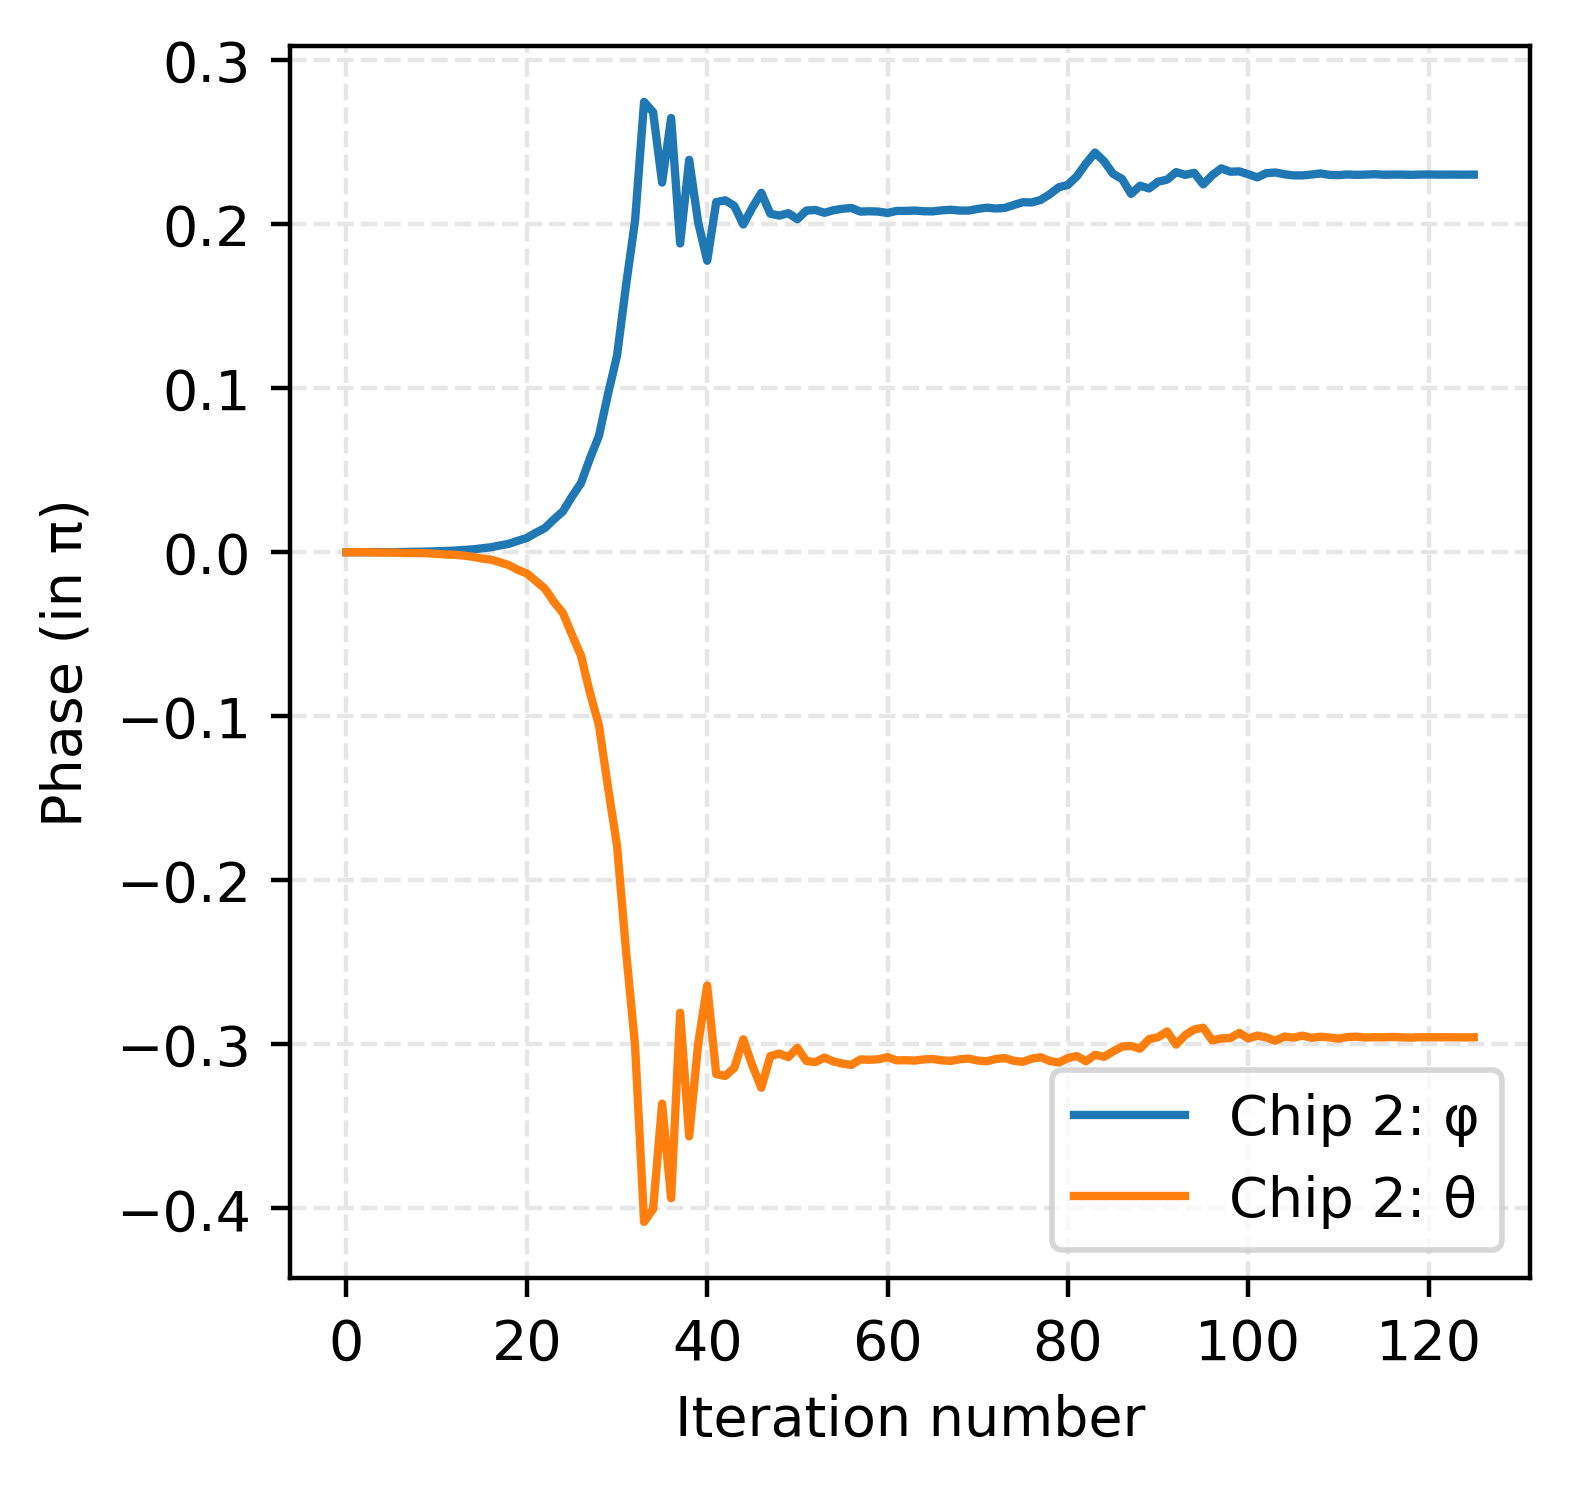

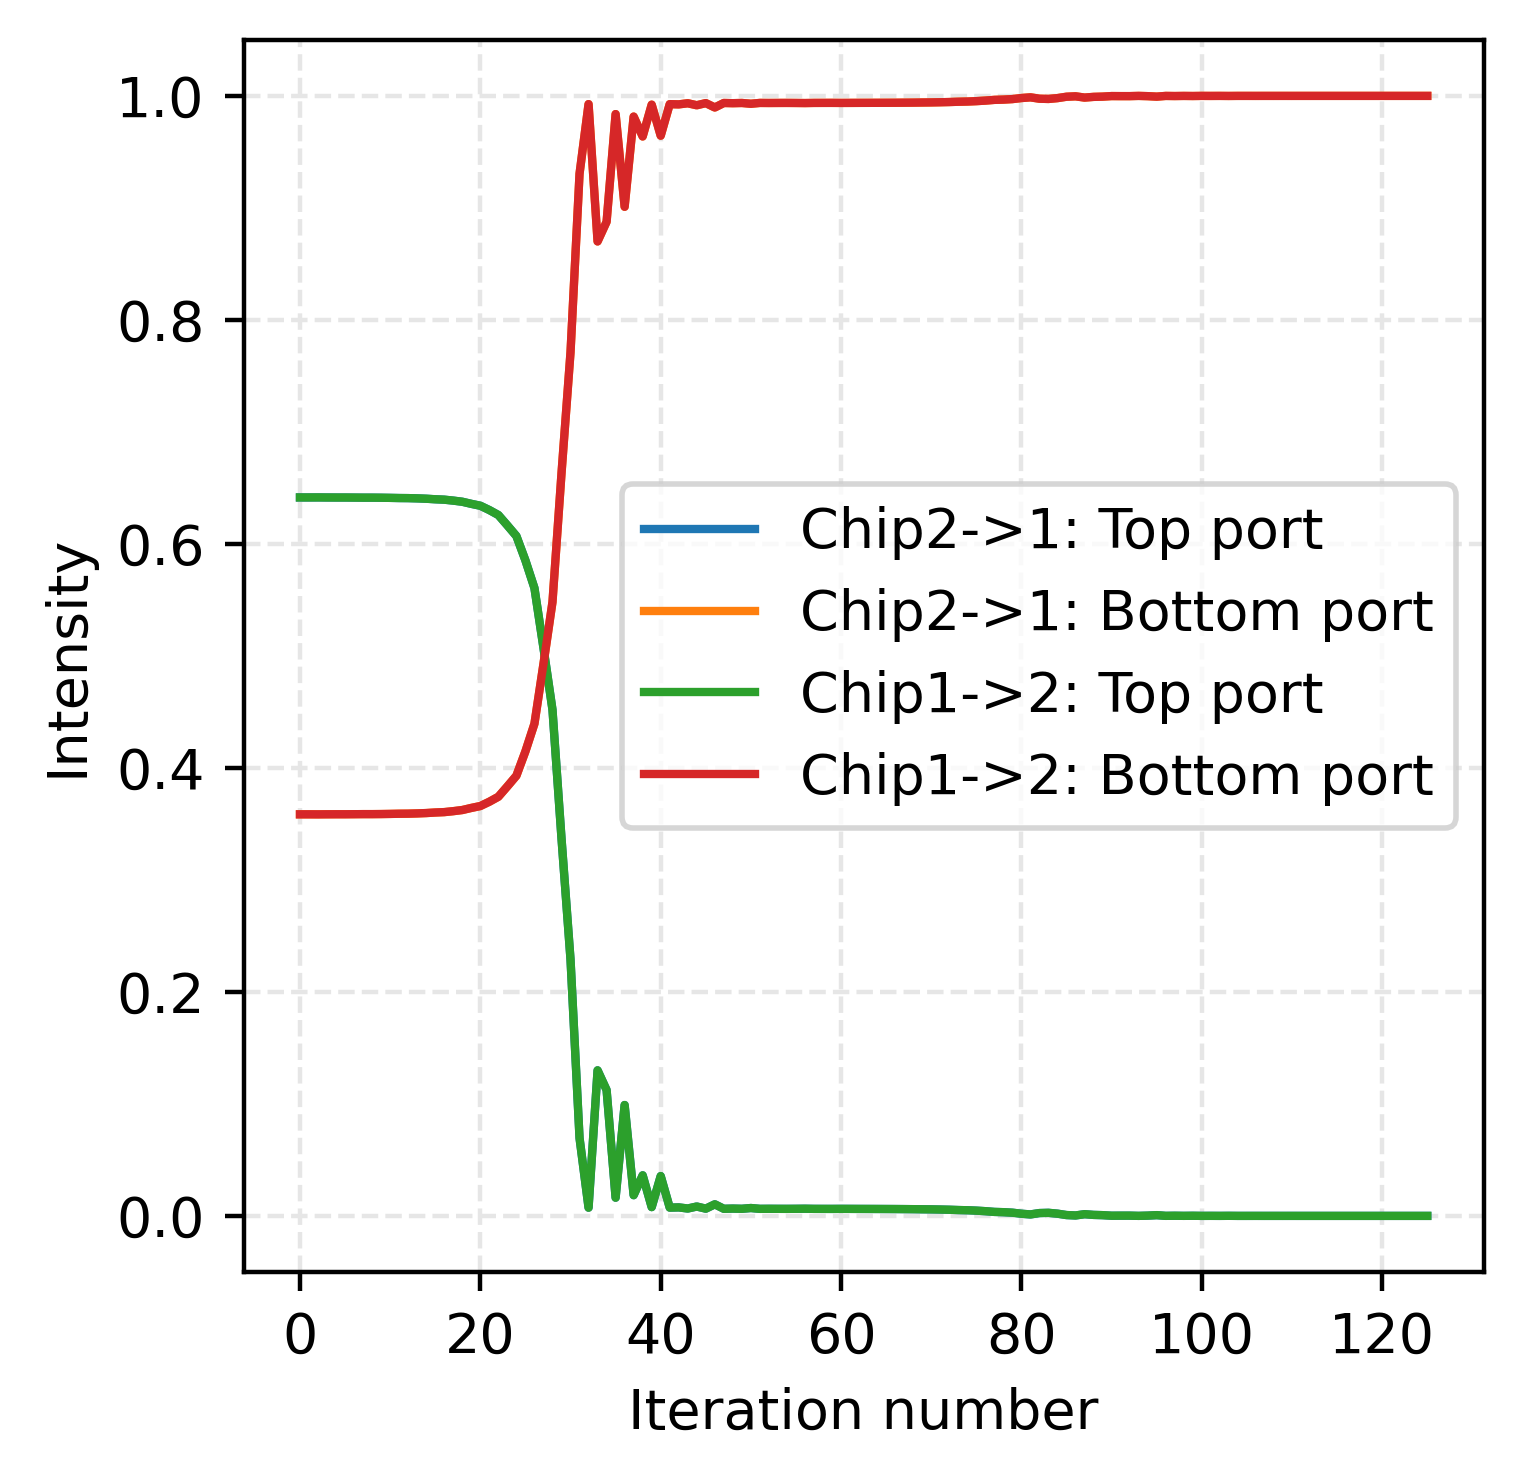

In [4]:
bounds = [(-math.pi, math.pi), (-math.pi, math.pi)]
lossless_link = ChipToChipLink()
opts = {'fatol': 1e-6}
params = []
result = minimize(objective, (0.0, 0.0),
                  bounds=bounds,
                  args=(lossless_link, params),
                  method='Nelder-Mead',
                  options=opts)

forward_output = np.abs(lossless_link.forward([1, 0]))**2
backward_output = np.abs(lossless_link.backward([1, 0]))**2
print(
    f"All 1-->2 signals go to the bottom? {np.allclose(forward_output, [0.0, 1.0])}"
)
print(
    f"All 2-->1 signals go to the bottom? {np.allclose(backward_output, [0.0, 1.0])}"
)
plot_optimization(params)

## Optimization with lossy link
Assuming asymmetric loss where the PSR has (0.8, 1.2) dB loss in the (TE, TM) modes

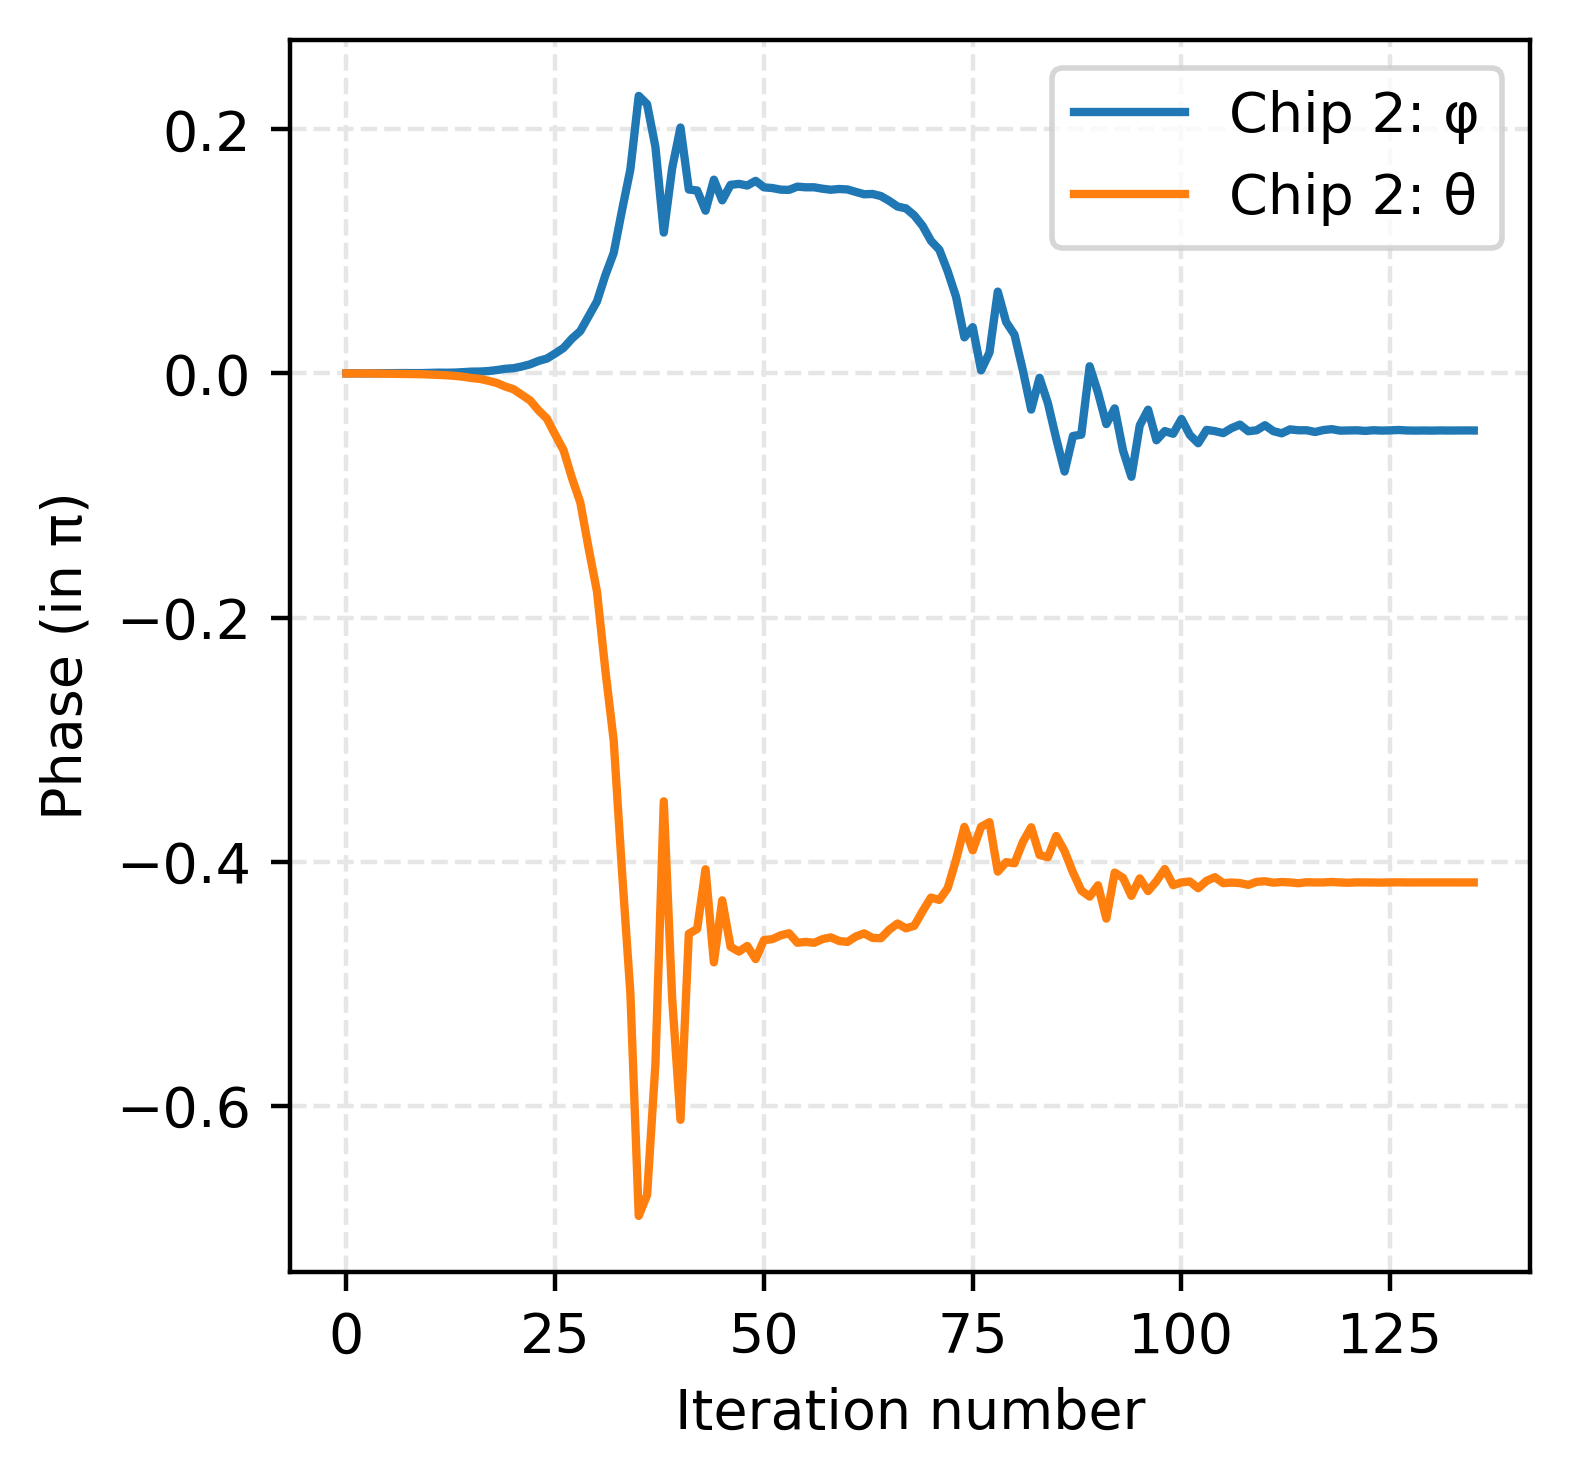

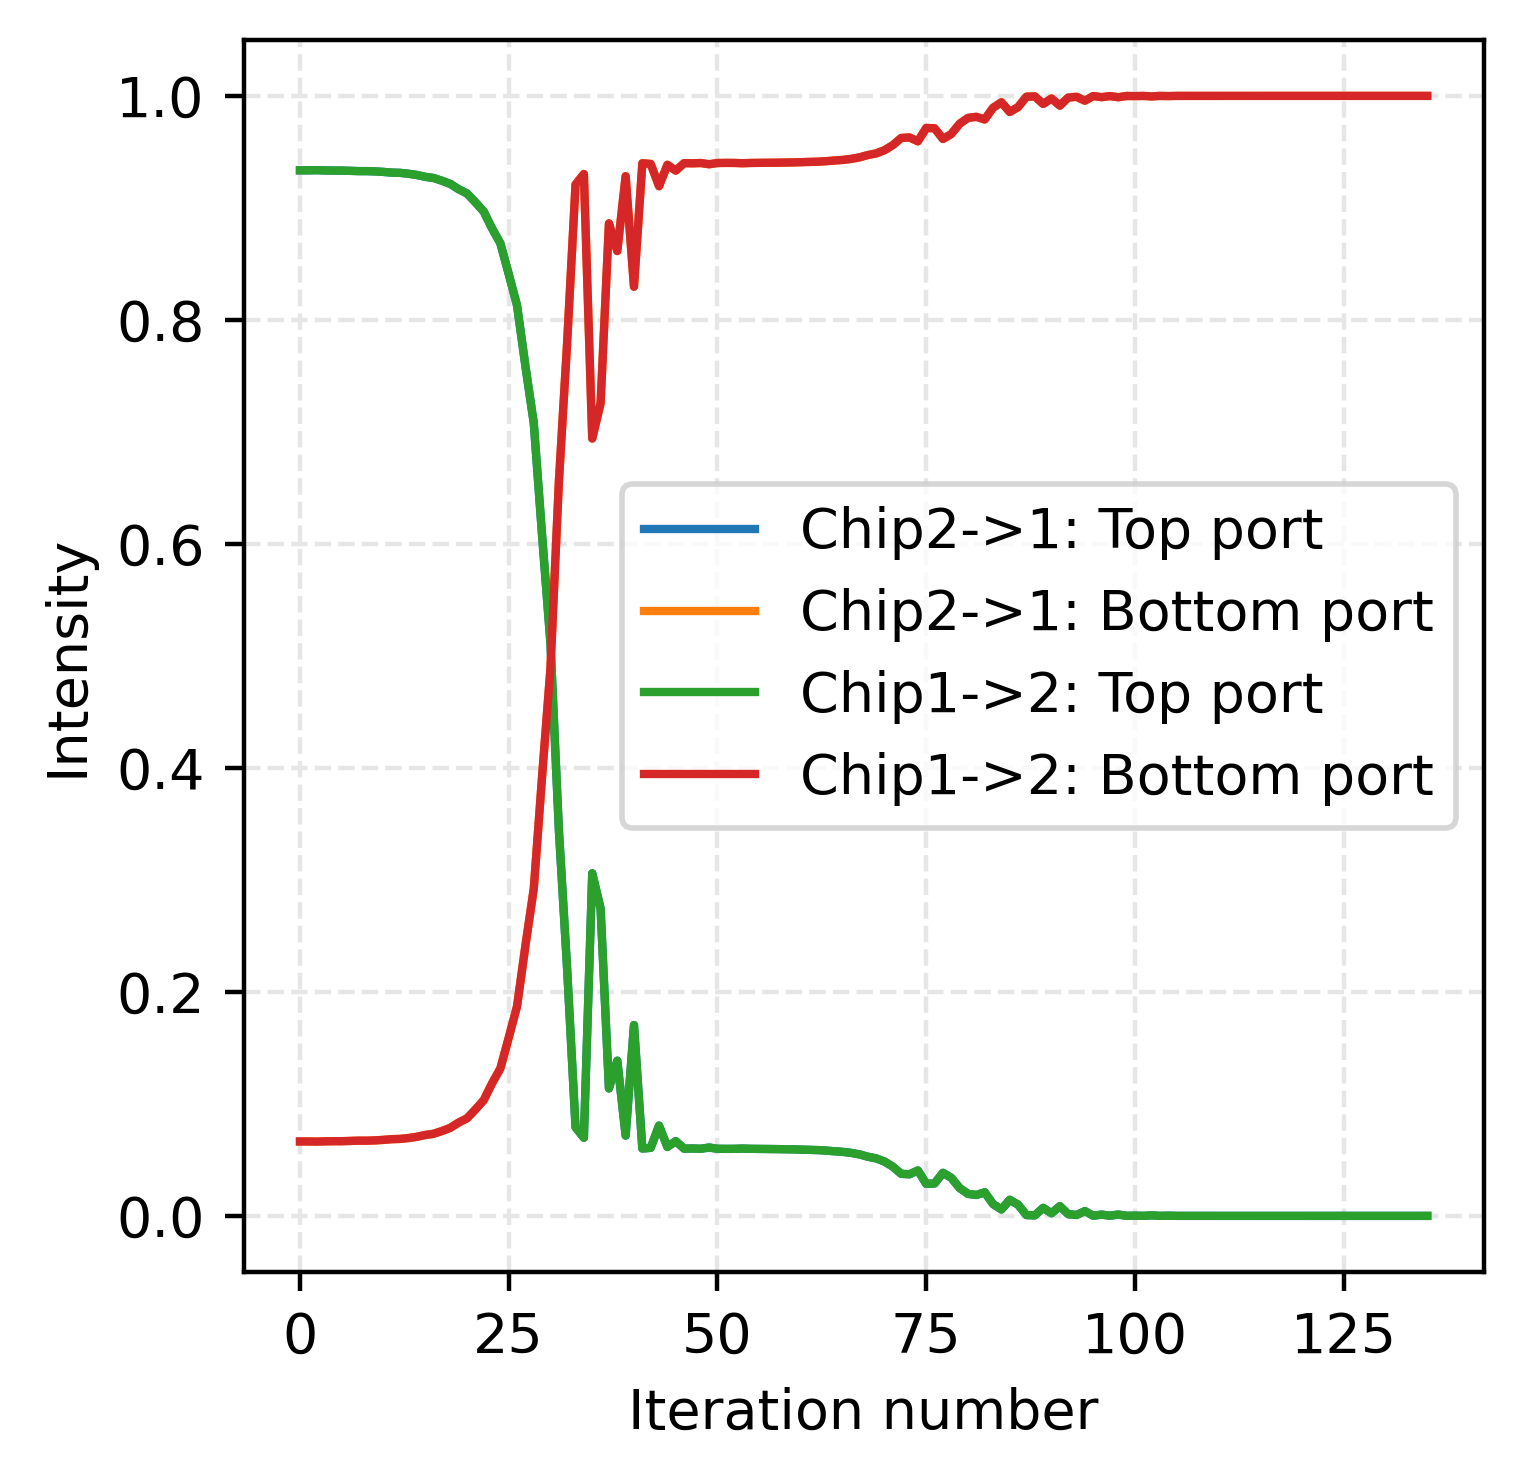

In [5]:
bounds = [(-math.pi, math.pi), (-math.pi, math.pi)]
loss_chip_1 = np.array([0.0, 0.0])
loss_chip_2 = np.array([0.0, 0.0])
link_with_loss = ChipToChipLink(loss_chip_1=loss_chip_1, loss_chip_2=loss_chip_2)
opts = {'fatol': 1e-6}
params = []
result = minimize(objective, (0.0, 0.0),
                  bounds=bounds,
                  args=(link_with_loss, params),
                  method='Nelder-Mead',
                  options=opts)

plot_optimization(params)